In [1]:
# Change working directory
%cd ..

d:\Workplaces\Thesis\ot-kpgf


In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import time
import json
import pandas as pd
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from optimal_transport.experiments import RobustnessExperiment
from typing import Tuple, Optional, List, Union, Dict

# To make this notebook's output stable across runs
np.random.seed(1)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

In [3]:
# Synthesize data
def mean(
    k: int, d: int, cluster_distance: int = 1,
) -> np.ndarray:
    mean = np.concatenate(
        [
            np.random.uniform(cluster_distance, cluster_distance*2, size=k)[:, None],
            np.arange((-k // 2 + 1)*cluster_distance, (k // 2 + 1)*cluster_distance, cluster_distance)[:, None],
            np.random.rand(k, d-2)
        ], 
        axis=1
    )
    return mean

def cov(
    k: int, d: int, scale: int
) -> np.ndarray:
    covs = []
    for _ in range(k):
        cov = np.eye(d)
        covs.append(cov)
    covs = np.array(covs) * scale
    return covs

def gauss_mixture(
    n: int, k: int,
    means: np.ndarray, covs: np.ndarray,
    **kwargs
) -> Tuple[np.ndarray, np.ndarray, List]:
    assert n % k == 0, "Each clusters should have equal number of samples."
    X, y, K = [], [], []
    for i in range(k):
        Xi = np.random.multivariate_normal(means[i], covs[i], size=(n // k - 1))
        Xi = np.concatenate((means[i][None, :], Xi))
        X.append(Xi) # (n, d)
        y.append(i * np.ones(n // k))
        K.append(i * (n // k))
    X, y = np.concatenate(X), np.concatenate(y)
    return X, y, K

# Dimensionality

In [4]:
# Setup the experiment
def random_orig_data(
    n: int, d: int, k: int,
    cluster_distance: int = 1,
    cluster_sparity: int = 1 
) -> Tuple[np.ndarray, np.ndarray, List]:
    means = mean(k, d, cluster_distance)
    covs = cov(k, d, cluster_sparity)
    return gauss_mixture(n, k, means, covs)

def add_gauss_dim(
    X: np.ndarray, 
    noise_dim: int, intensity: float = 1
) -> np.ndarray:
    if noise_dim == 0:
        return X
    X_ = X.copy()
    noise = np.random.uniform(low=0, high=intensity, size=(X.shape[0], noise_dim))
    #noise = np.random.normal(scale=intensity, size=(X.shape[0], noise_dim))
    X_ = np.concatenate([X, noise], axis=1) # n x (d + d_noise)
    return X_

Dimension: 10, Accuracy: {'KeypointFOT': 0.9875, 'FOT': 0.95, 'LOT': 0.575, 'OT': 0.825}, Deviation: {'KeypointFOT': 0, 'FOT': 0, 'LOT': 0, 'OT': 0},  Runtime: {'KeypointFOT': 1.7197513580322266, 'FOT': 1.7567241191864014, 'LOT': 0.683584451675415, 'OT': 0.0019986629486083984}
Dimension: 20, Accuracy: {'KeypointFOT': 0.975, 'FOT': 0.975, 'LOT': 0.4625, 'OT': 0.65}, Deviation: {'KeypointFOT': 0.34917655073253123, 'FOT': 0.3462566370198135, 'LOT': 1.210062488667424e-10, 'OT': 1.396424004376894},  Runtime: {'KeypointFOT': 11.60041093826294, 'FOT': 3.1384055614471436, 'LOT': 0.6780877113342285, 'OT': 0.002001523971557617}
Dimension: 30, Accuracy: {'KeypointFOT': 0.8375, 'FOT': 1.0, 'LOT': 0.5125, 'OT': 0.6375}, Deviation: {'KeypointFOT': 0.4472695279119682, 'FOT': 0.2984270899557025, 'LOT': 4.2901322818977904e-10, 'OT': 1.3784048752090223},  Runtime: {'KeypointFOT': 3.338449001312256, 'FOT': 1.6572279930114746, 'LOT': 0.6776015758514404, 'OT': 0.003003358840942383}
Dimension: 40, Accuracy:

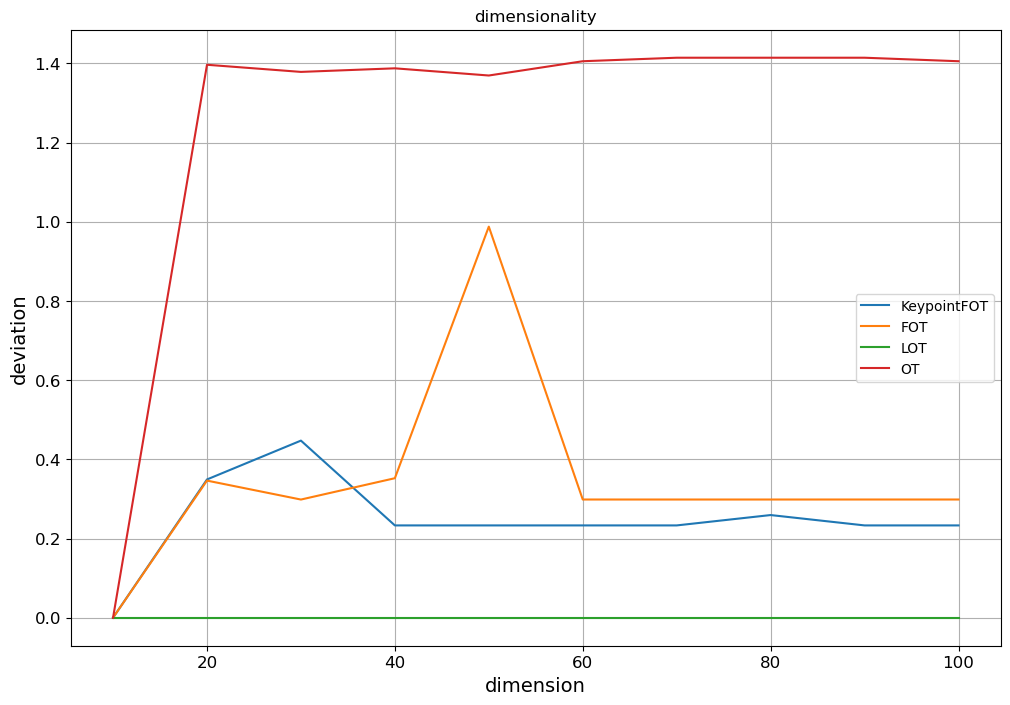

In [16]:
#@title Run the experiment
n_anchors = 4
n_keypoints = 4
k = 4
orig_dim = 10
max_dim = 100
cluster_num_samples = 20
n = cluster_num_samples * k
noise_intensity = 1
source_distance, source_sparity = 1, 0.1
target_distance, target_sparity = source_distance*2, source_sparity*2
step = 10

# init OTs
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.0005, temperature=0.01, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

# init experiment and logger
exp = RobustnessExperiment(model=models, exp_name="dimensionality", log_dir="logs")
exp.record_[exp.exp_name] = {model_id: {"dimension": [], "accuracy": [], "deviation": [],  "runtime": []} for model_id in exp.model}
exp_range = [orig_dim] + [i for i in range(max(orig_dim, step), max_dim+1, step)]
if orig_dim == step: 
    exp_range = exp_range[1:]
P0 = {k: None for k in exp.model.keys()}

# test on increasing dimensions
for dim in exp_range:
    # generate data
    Xs, ys, Ks = random_orig_data(n, dim, k, 
                                cluster_distance=source_distance, 
                                cluster_sparity=source_sparity)
    Xt, yt, Kt = random_orig_data(n, dim, k, 
                                cluster_distance=target_distance, 
                                cluster_sparity=target_sparity)
    Xt[:, 0] = -Xt[:, 0]
    K = [(Ks[i], Kt[i]) for i in range(len(Ks))][:n_keypoints]
    a, b = np.ones(Xs.shape[0]) / Xs.shape[0], np.ones(Xt.shape[0]) / Xt.shape[0]

    Xs_ = Xs
    Xt_ = Xt
    #Xs_ = add_gauss_dim(Xs, dim-orig_dim, intensity=noise_intensity)
    #Xt_ = add_gauss_dim(Xt, dim-orig_dim, intensity=noise_intensity)

    for model_id, model in exp.model.items():
        start = time.time()
        ys_pred = exp.run(Xs_, Xt_, a, b, ys, yt, model, K=K)

        if dim == orig_dim:
            P0[model_id] = model.P_
            dev = 0
        else:
            dev = np.linalg.norm(model.P_ - P0[model_id]) / np.linalg.norm(P0[model_id])
        
        exp.record_[exp.exp_name][model_id]["deviation"].append(dev)
        exp.record_[exp.exp_name][model_id]["dimension"].append(dim)
        exp.record_[exp.exp_name][model_id]["accuracy"].append(exp.accuracy(ys_pred, ys))
        exp.record_[exp.exp_name][model_id]["runtime"].append(time.time() - start)
    
    dev_log = {model_id: exp.record_[exp.exp_name][model_id]["deviation"][-1] for model_id in exp.record_[exp.exp_name]}
    acc_log = {model_id: exp.record_[exp.exp_name][model_id]["accuracy"][-1] for model_id in exp.record_[exp.exp_name]}
    runtime_log = {model_id: exp.record_[exp.exp_name][model_id]["runtime"][-1] for model_id in exp.record_[exp.exp_name]}
    #exp.checkpoint()
    exp.logger.info(f"Dimension: {dim}, Accuracy: {acc_log}, Deviation: {dev_log},  Runtime: {runtime_log}")

# plot deviation vs. dimension
exp.plot(x_axis="dimension", y_axis="deviation")

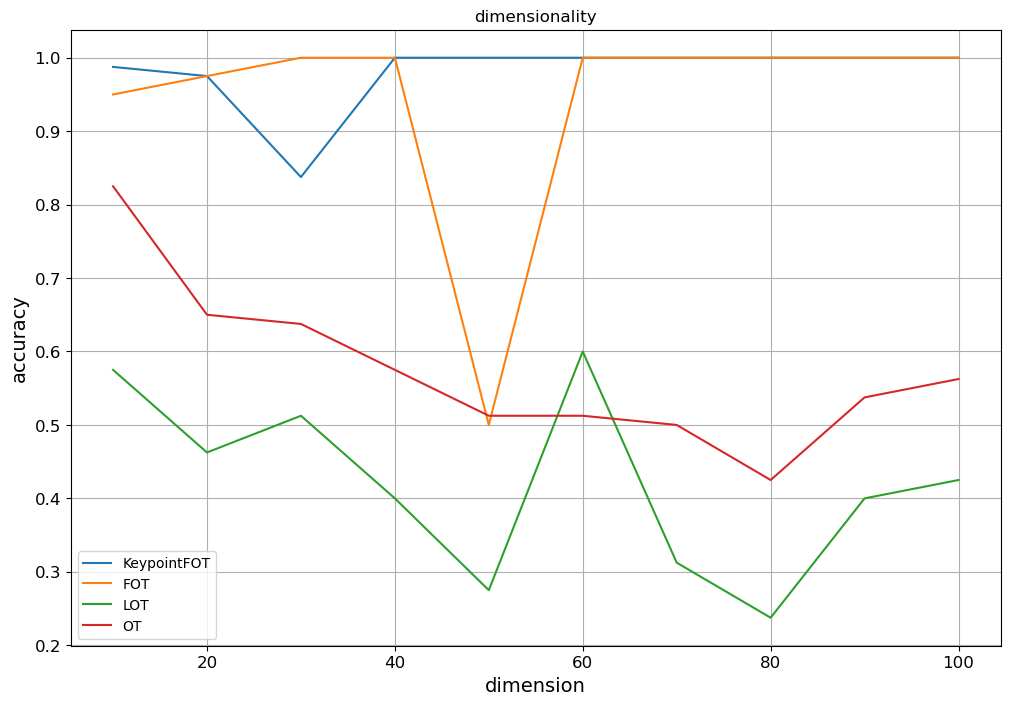

In [17]:
# Plot accuracy vs. dimensions
exp.plot(x_axis="dimension", y_axis="accuracy")

# Outlier Rate